In [1]:
pip install scikit-fuzzy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install library (jalankan di terminal, bukan di dalam python)
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [3]:
# =============================================
# 1. IMPORT DATASET & AMBIL YANG PENTING
# =============================================
df = pd.read_csv("sleep_quality_dataset.csv")

# Ambil kolom penting
df = df[[
    "date_recorded",
    "duration_minutes",
    "gender"
]]

# Convert tanggal
df["date_recorded"] = pd.to_datetime(df["date_recorded"])
df["year"] = df["date_recorded"].dt.year

# Buat jam tidur
df["sleep_hours"] = df["duration_minutes"] / 60

# Filter tahun 2018–2025 saja
df = df[(df["year"] >= 2018) & (df["year"] <= 2025)]

print(df.head(), "\n\n")

  date_recorded  duration_minutes  gender  year  sleep_hours
0    2024-04-03               445  female  2024     7.416667
1    2018-12-05               295    male  2018     4.916667
2    2025-03-30               435  female  2025     7.250000
3    2023-05-11               466    male  2023     7.766667
4    2019-12-11               372    male  2019     6.200000 




In [4]:
# =============================================
# 2. DEFINISI FUZZY LOGIC
# =============================================
sleep = ctrl.Antecedent(np.arange(0, 13, 1), 'sleep')
quality = ctrl.Consequent(np.arange(0, 11, 1), 'quality')

sleep['kurang'] = fuzz.trimf(sleep.universe, [0, 0, 5])
sleep['cukup']  = fuzz.trimf(sleep.universe, [4, 6.5, 9])
sleep['lebih']  = fuzz.trimf(sleep.universe, [8, 12, 12])

quality['buruk']        = fuzz.trimf(quality.universe, [0, 0, 4])
quality['normal']       = fuzz.trimf(quality.universe, [3, 5, 7])
quality['sangat_baik']  = fuzz.trimf(quality.universe, [6, 10, 10])

rule1 = ctrl.Rule(sleep['kurang'], quality['buruk'])
rule2 = ctrl.Rule(sleep['cukup'],  quality['normal'])
rule3 = ctrl.Rule(sleep['lebih'],  quality['sangat_baik'])

sleep_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
sleep_sim = ctrl.ControlSystemSimulation(sleep_ctrl)

In [22]:
# =============================================
# 3. HITUNG FUZZY UNTUK SEMUA DATASET
# =============================================
fuzzy_results = []

for idx, row in df.iterrows():
    sleep_sim.input['sleep'] = row["sleep_hours"]
    sleep_sim.compute()
    hasil = sleep_sim.output["quality"]
    fuzzy_results.append(hasil)

df["fuzzy_score"] = fuzzy_results

# Tentukan kategori
def kategori_fuzzy(x):
    if x <= 4:
        return "Buruk"
    elif x <= 7:
        return "Normal"
    else:
        return "Sangat Baik"

df["fuzzy_category"] = df["fuzzy_score"].apply(kategori_fuzzy)




=== FUZZY DARI DATA TAHUN 2024 ===
Rata-rata lama tidur: 7.47 jam
Output Fuzzy       : 5.00
Kategori Tahun     : Normal 😌


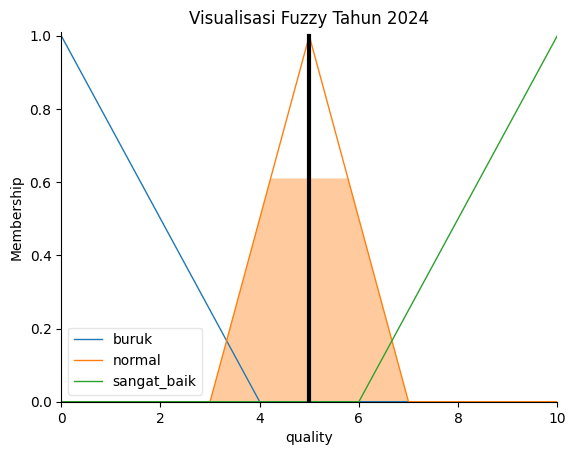

In [34]:
# =============================================
# 4. FUZZY BERDASARKAN TAHUN (INPUT SENDIRI)
# =============================================

df["date_recorded"] = pd.to_datetime(df["date_recorded"], errors="coerce")
df["year"] = df["date_recorded"].dt.year

tahun_input = 2024  # bebas diubah

df_year = df[df["year"] == tahun_input]

if len(df_year) == 0:
    print(f"⚠️ Tidak ada data untuk tahun {tahun_input}")
else:
    sleep_avg = df_year["sleep_hours"].mean()

    print(f"\n=== FUZZY DARI DATA TAHUN {tahun_input} ===")
    print(f"Rata-rata lama tidur: {sleep_avg:.2f} jam")

    # ===== BUAT SIMULASI BARU AGAR GRAFIK TIDAK DIEM =====
    sleep_sim_tahun = ctrl.ControlSystemSimulation(sleep_ctrl)

    sleep_sim_tahun.input['sleep'] = sleep_avg
    sleep_sim_tahun.compute()

    hasil_tahun = sleep_sim_tahun.output['quality']

    if hasil_tahun <= 4:
        kategori_tahun = "Buruk 😴"
    elif hasil_tahun <= 7:
        kategori_tahun = "Normal 😌"
    else:
        kategori_tahun = "Sangat Baik 😃"

    print(f"Output Fuzzy       : {hasil_tahun:.2f}")
    print(f"Kategori Tahun     : {kategori_tahun}")

    # === Visualisasi fuzzy berdasarkan tahun ===
    quality.view(sim=sleep_sim_tahun)
    plt.title(f"Visualisasi Fuzzy Tahun {tahun_input}")
    plt.show()


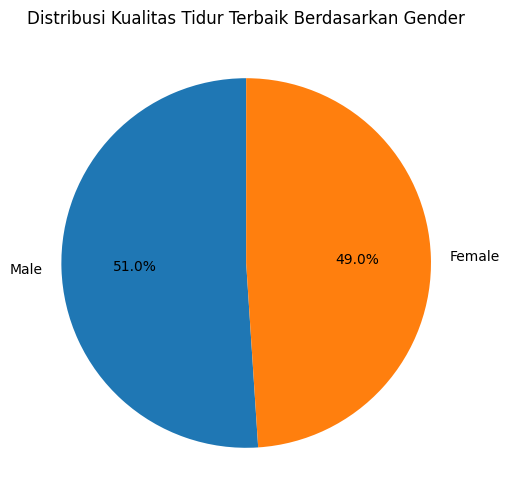

In [16]:
# =============================================
# 5. PIE CHART: KUALITAS TIDUR TERBAIK BERDASARKAN GENDER
# =============================================

# Ambil data dengan kualitas tidur 'Sangat Baik' (buat salinan aman)
df_best = df[df["fuzzy_category"] == "Sangat Baik"].copy()

# Normalisasi gender biar konsisten
df_best.loc[:, "gender"] = df_best["gender"].astype(str).str.strip().str.capitalize()

# Filter hanya Male & Female
df_best = df_best[df_best["gender"].isin(["Male", "Female"])]

# Hitung jumlah gender
gender_counts = df_best["gender"].value_counts()

# Plot hanya jika ada data
if len(gender_counts) > 0:
    plt.figure(figsize=(6,6))
    plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", startangle=90)
    plt.title("Distribusi Kualitas Tidur Terbaik Berdasarkan Gender")
    plt.show()
else:
    print("⚠️ Tidak ada data kategori 'Sangat Baik' untuk Male/Female.")


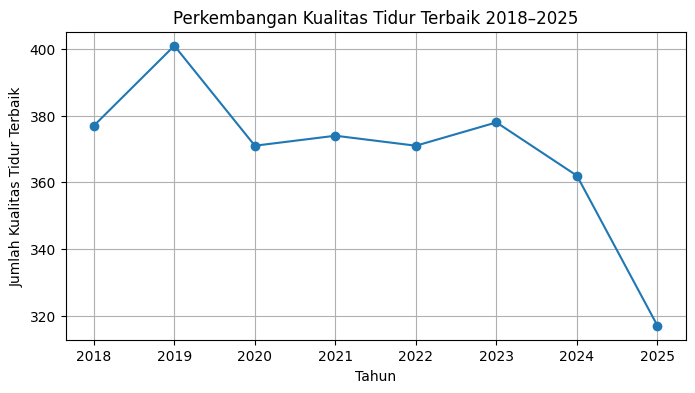

In [17]:
# =============================================
# 6. GRAFIK GARIS: PERKEMBANGAN KUALITAS TIDUR TERBAIK 2018–2025
# =============================================
trend = df[df["fuzzy_category"] == "Sangat Baik"].groupby("year").size()

plt.figure(figsize=(8,4))
plt.plot(trend.index, trend.values, marker="o")
plt.title("Perkembangan Kualitas Tidur Terbaik 2018–2025")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Kualitas Tidur Terbaik")
plt.grid()
plt.show()

In [18]:
# =============================================
# 7. CARI TAHUN TERBAIK
# =============================================
best_year = trend.idxmax()
print(f"\nTahun dengan kualitas tidur terbaik berdasarkan Fuzzy: {best_year}")



Tahun dengan kualitas tidur terbaik berdasarkan Fuzzy: 2019
